In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [22]:
DATA_PATH = "../out1x.json"

# Techniques and labels
TECHNIQUES = ["MDS", "TSNE", "RANDOM"]
TECH_LABELS = {"MDS": "MDS", "TSNE": "TSNE", "RANDOM": "RND"}

# Metrics + colors
METRIC_SUFFIX_MAP = {
    "norm": "NS",
    "scalenorm": "SNS",
    "kruskal": "NMS",
    "sheppard": "SGS",
}
METRIC_COLORS = {
    "NS": "#d62728",
    "SNS": "#1f77b4",
    "NMS": "#ff7f0e",
    "SGS": "#9467bd",
}
METRIC_ORDER = list(METRIC_SUFFIX_MAP.values())

In [23]:
with open(DATA_PATH, "r") as f:
    raw = json.load(f)

In [24]:
values = {(tech, METRIC_SUFFIX_MAP[suf]): [] for tech in TECHNIQUES for suf in METRIC_SUFFIX_MAP}
for dataset_key, metrics in raw.items():
    for full_key, v in metrics.items():
        if "_" not in full_key:
            continue
        tech, suf = full_key.split("_", 1)
        if tech in TECHNIQUES and suf in METRIC_SUFFIX_MAP:
            try:
                values[(tech, METRIC_SUFFIX_MAP[suf])].append(float(v))
            except (TypeError, ValueError):
                continue

In [ ]:
all_vals = np.array([vv for lst in values.values() for vv in lst], dtype=float)
if all_vals.size == 0:
    raise RuntimeError("No data found to plot.")
ymin_raw = -0.1 
ybreak = 1.0
ymax_raw = float(np.nanmax(all_vals))

In [ ]:
# Log-like transform above 1
target_low_frac = 0.70 
gap = 0.12        

if ymax_raw > ybreak:
    low_len = ybreak - ymin_raw
    H = low_len / target_low_frac
    high_len_t = max(H - low_len - gap, 0.05 * low_len)
    scale_alpha = high_len_t / np.log1p(max(ymax_raw - ybreak, 1e-6))
else:
    scale_alpha = 1.0

def transform_log_like(y):
    y = np.asarray(y, dtype=float)
    if ymax_raw <= ybreak:
        return y
    out = np.empty_like(y)
    low_mask = y <= ybreak
    out[low_mask] = y[low_mask]
    out[~low_mask] = ybreak + gap + scale_alpha * np.log1p(y[~low_mask] - ybreak)
    return out

In [ ]:
# Build transformed values map
values_t = {}
for k, lst in values.items():
    values_t[k] = transform_log_like(lst).tolist()

In [ ]:
# Grouped boxplot data
tech_order = TECHNIQUES
metric_order = list(METRIC_SUFFIX_MAP.values())
group_spacing = 1.5
box_width = 0.22
num_metrics = len(metric_order)
offsets = np.linspace(-(num_metrics-1)/2, (num_metrics-1)/2, num_metrics) * (box_width*1.2)

plot_data, positions, colors = [], [], []
for gi, tech in enumerate(tech_order):
    group_center = gi * group_spacing
    for mi, metric_name in enumerate(metric_order):
        plot_data.append(values_t[(tech, metric_name)])
        positions.append(group_center + offsets[mi])
        colors.append(METRIC_COLORS[metric_name])

In [ ]:
# Axis limits
flat = np.concatenate([np.array(v, dtype=float) for v in values_t.values() if len(v)>0])
ymin_t = transform_log_like([ymin_raw])[0] 
ymax_t = float(np.nanmax(flat))
pad_top = 0.02 * (ymax_t - ymin_t if ymax_t > ymin_t else 1.0)

In [ ]:
# Plot
plt.figure(figsize=(10, 5), dpi=200)
bp = plt.boxplot(
    plot_data,
    positions=positions,
    widths=box_width,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(linewidth=1.5, color="black"),
    whiskerprops=dict(linewidth=1.25, color="#444444"),
    capprops=dict(linewidth=1.25, color="#444444"),
    boxprops=dict(linewidth=1.25, color="#444444"),
)
for box, c in zip(bp["boxes"], colors):
    box.set_facecolor(c)
    box.set_alpha(0.9)

group_centers = [i * group_spacing for i in range(len(tech_order))]
plt.xticks(group_centers, [TECH_LABELS[t] for t in tech_order], fontsize=11)
plt.ylabel("Score", fontsize=12)

# Ticks
low_ticks = np.concatenate((np.array([-0.1, 0.0]), np.linspace(0.2, 1.0, 5)))
if ymax_raw > ybreak:
    candidates = np.array([1.25, 1.5, 2, 3, 5, 7.5, 10, 15, 20, 30, 40, 50], dtype=float)
    upper_ticks = candidates[(candidates > 1.0) & (candidates <= ymax_raw + 1e-9)]
    if upper_ticks.size > 5:
        idx = np.round(np.linspace(0, upper_ticks.size-1, 5)).astype(int)
        upper_ticks = upper_ticks[idx]
else:
    upper_ticks = np.array([], dtype=float)

tick_vals = np.concatenate([low_ticks, upper_ticks])
tick_pos = transform_log_like(tick_vals)
tick_labels = [f"{t:g}" for t in tick_vals]
plt.yticks(tick_pos, tick_labels, fontsize=11)

plt.ylim(ymin_t, ymax_t + pad_top)
plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
plt.margins(x=0.05)

legend_handles = [Patch(facecolor=METRIC_COLORS[m], edgecolor="#444444", label=m) for m in metric_order]
plt.legend(handles=legend_handles, title="Metric", fontsize=10, title_fontsize=11, frameon=True, loc="upper left")

# Break marker at y=1
ax = plt.gca()
y_break_t = transform_log_like([ybreak])[0]
def draw_break_marker(y_t):
    y0, y1 = ax.get_ylim()
    y_frac = (y_t - y0) / (y1 - y0)
    dx = 0.015
    dy = 0.018
    for x0 in (0.0, 1.0):
        ax.plot([x0 - dx, x0 + dx], [y_frac - dy, y_frac + dy], transform=ax.transAxes,
                clip_on=False, color="#444444", linewidth=1.4)
draw_break_marker(y_break_t)

plt.tight_layout()
out_pdf = "./stress_boxplots.pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()

In [25]:
xmin_map = -0.1
xbreak = 1.0
all_raw = np.array([x for lst in values.values() for x in lst], dtype=float)
xmax_raw = float(np.nanmax(all_raw)) if all_raw.size else 1.0

target_low_frac = 0.70
gap = 0.12

if xmax_raw > xbreak:
    low_len = xbreak - xmin_map
    W = low_len / target_low_frac
    high_len_t = max(W - low_len - gap, 0.05 * low_len)
    alpha = high_len_t / np.log1p(max(xmax_raw - xbreak, 1e-6))
else:
    alpha = 1.0

In [26]:
def x_transform(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    low = x <= xbreak
    out[low] = x[low]
    out[~low] = xbreak + gap + alpha * np.log1p(x[~low] - xbreak)
    return out

def kde_gaussian(x, grid, bandwidth=None):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.zeros_like(grid)
    if bandwidth is None:
        std = np.std(x, ddof=1) if x.size > 1 else 1.0
        bandwidth = 1.06 * std * (x.size ** (-1/5)) if std > 0 else 0.1
        bandwidth = max(bandwidth, 1e-3)
    u = (grid[:, None] - x[None, :]) / bandwidth
    kern = np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
    dens = kern.mean(axis=1) / bandwidth
    return dens

In [27]:
metric_to_y = {m: (len(METRIC_ORDER)-1 - i) for i, m in enumerate(METRIC_ORDER)}
band_scale = 0.8
band_margin = 0.25

In [28]:
def choose_upper_ticks(max_val, n=3):
    candidates = np.array([1.25, 1.5, 2, 3, 5, 7.5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 300], dtype=float)
    upper = candidates[(candidates > 1.0) & (candidates <= max_val + 1e-9)]
    if upper.size == 0:
        return upper
    if upper.size <= n:
        return upper
    idx = np.round(np.linspace(0, upper.size - 1, n)).astype(int)
    return upper[idx]

def build_ticks(xmin_display, xmax_raw, n_upper):
    if xmin_display <= -0.3:
        left_ticks = np.array([-0.3, -0.1, 0.0, 0.5, 1.0])
    else:
        left_ticks = np.array([-0.1, 0.0, 0.25, 0.5, 0.75, 1.0])
    upper = choose_upper_ticks(xmax_raw, n=n_upper)
    tick_vals = np.concatenate([left_ticks, upper])
    tick_pos = x_transform(tick_vals)
    tick_labels = [f"{t:g}" for t in tick_vals]
    return tick_pos, tick_labels

In [31]:
panel_cfg = {
    "MDS": {"xmin": 0, "n_upper": 3, "label_rotation": 32, "label_size": 10},
    "TSNE": {"xmin": 0, "n_upper": 3, "label_rotation": 35, "label_size": 10},
    "RANDOM": {"xmin": 0, "n_upper": 3, "label_rotation": 20, "label_size": 10},
}

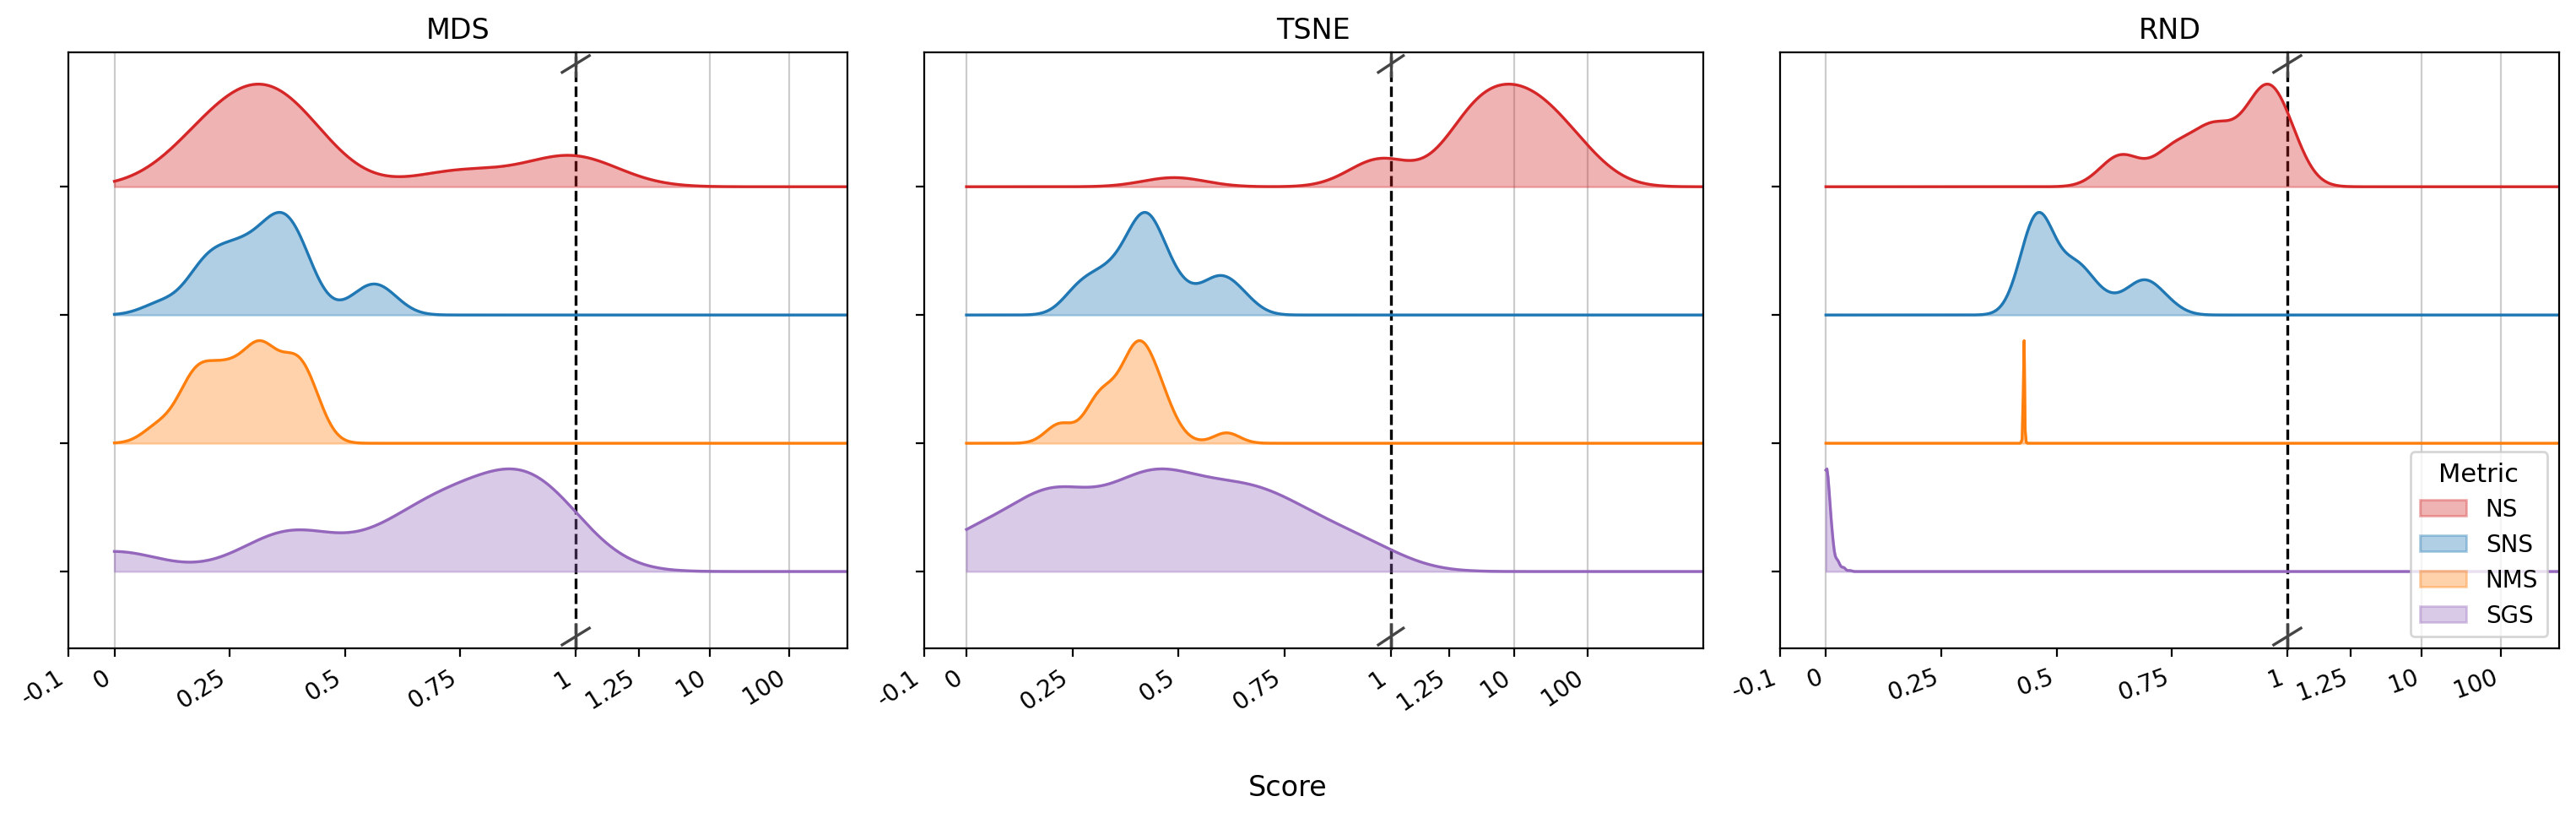

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True, dpi=200)

for ax, tech in zip(axes, TECHNIQUES):
    cfg = panel_cfg[tech]
    xmin_display = cfg["xmin"]
    xmin_t = x_transform([xmin_display])[0]
    xmax_t = x_transform([xmax_raw])[0] if xmax_raw > xbreak else xmax_raw

    width = xmax_t - xmin_t
    pad_left = 0.03 * width
    pad_right = (0.18 if tech == "TSNE" else 0.08) * width

    grid_t = np.linspace(xmin_t, xmax_t + pad_right, 700)

    # Draw ridges
    for m in METRIC_ORDER:
        y0 = metric_to_y[m]
        data_t = x_transform(values[(tech, m)])
        dens = kde_gaussian(data_t, grid_t)
        if dens.max() > 0:
            dens = dens / dens.max() * band_scale
        color = METRIC_COLORS[m]
        ax.plot(grid_t, y0 + dens, linewidth=1.2, color=color)
        ax.fill_between(grid_t, y0, y0 + dens, alpha=0.35, facecolor=color, edgecolor=color, linewidth=0.8)

    # y headroom
    top_y_index = len(METRIC_ORDER) - 1
    ylim_bottom = -0.6
    ylim_top = top_y_index + band_scale + band_margin
    ax.set_ylim(ylim_bottom, ylim_top)

    ax.set_yticks(sorted(metric_to_y.values()))
    inv_labels = [k for k,v in sorted(metric_to_y.items(), key=lambda kv: kv[1])]
    if ax is axes[0]:
        ax.set_yticklabels(inv_labels)
    else:
        ax.set_yticklabels([])

    ax.set_xlim(xmin_t - pad_left, xmax_t + pad_right)
    tick_pos, tick_labels = build_ticks(xmin_display, xmax_raw, cfg["n_upper"])
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=cfg["label_rotation"], ha="right", fontsize=cfg["label_size"])

    ax.set_title(f"{TECH_LABELS[tech]}")
    ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
    
    for v in [0, 1, 10, 100]:
        xt = x_transform([v])[0]
        if v == 1:
            ax.axvline(xt, color="black", linestyle="--", linewidth=1.2, zorder=0)
        else:
            ax.axvline(xt, color="#cccccc", linestyle="-", linewidth=0.8, zorder=0)

    ax.grid(False)

    # Break marker at x=1
    x_break_t = x_transform([xbreak])[0]
    y0_lim, y1_lim = ax.get_ylim()
    dy = 0.04 * (y1_lim - y0_lim)
    ax.plot([x_break_t, x_break_t], [y0_lim, y0_lim + dy], color="#444444", linewidth=1.2, clip_on=False)
    ax.plot([x_break_t, x_break_t], [y1_lim - dy, y1_lim], color="#444444", linewidth=1.2, clip_on=False)
    ax.plot([x_break_t - 0.02*width, x_break_t + 0.02*width],
            [y0_lim + 0.006*(y1_lim - y0_lim), y0_lim + dy - 0.006*(y1_lim - y0_lim)],
            color="#444444", linewidth=1.2, clip_on=False)
    ax.plot([x_break_t - 0.02*width, x_break_t + 0.02*width],
            [y1_lim - dy + 0.006*(y1_lim - y0_lim), y1_lim - 0.006*(y1_lim - y0_lim)],
            color="#444444", linewidth=1.2, clip_on=False)

# Legend
rand_ax = axes[2]
handles = [Patch(facecolor=METRIC_COLORS[m], edgecolor=METRIC_COLORS[m], label=m, alpha=0.35) for m in METRIC_ORDER]
leg = rand_ax.legend(handles=handles, title="Metric", loc="lower right", frameon=True, fontsize=10, title_fontsize=11)
for patch in leg.get_patches():
    patch.set_linewidth(1.0)

fig.supxlabel("Score", fontsize=12)
plt.tight_layout(rect=(0.02, 0.02, 0.98, 0.97))

out_pdf = "./stress_ridgeline.pdf"
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()